In [1]:
import sys
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision.utils import save_image
import argparse
import numpy as np
import matplotlib.pyplot as plt

from bgm import *
from sagan import *
from causal_model import *
import os
import random
import utils

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Resize, Normalize

from tqdm.notebook import tqdm
import seaborn as sns
import pprint

In [2]:
class ImageDataset(Dataset):
    def __init__(self,root_folder,transform, cols = None):
        self.transform=transform
        self.img_folder=root_folder+'img/img_align_celeba/'
        
        self.attr = pd.read_csv(root_folder+'attr.csv').replace(-1,0)
        self.image_names = self.attr.pop('image_id')
        if cols is not None:
            self.attr = self.attr[cols]    
        self.num_feat = len(self.attr.columns)
        self.order = list(self.attr.columns)
        
        self.attr = self.attr.values
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)
        label = torch.tensor(self.attr[index], dtype = torch.float)

        return image, label

In [3]:
def get_train_dataloader(root_folder, img_dim=64, batch_size=32, cols = None):

    transform = Compose([Resize((img_dim, img_dim)),
                        ToTensor(),
                        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    training_data = ImageDataset(root_folder='dataset/celebA/',transform=transform, cols = cols)
    train_dataloader = DataLoader(training_data, batch_size = batch_size, num_workers = 2, 
                                  shuffle = True, prefetch_factor = 4)
    return train_dataloader

In [4]:
in_channels = 3
fc_size = 2048
latent_dim = 100

img_dim = 64
batch_size = 128

g_conv_dim = 32
enc_dist='gaussian'
enc_arch='resnet'
enc_fc_size=2048
enc_noise_dim=128
dec_dist = 'implicit'
prior = 'linscm'

cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']
num_label = len(cols)

A = torch.zeros((num_label, num_label))
A[0, 2:6] = 1
A[1, 4] = 1

In [5]:
model = BGM(latent_dim, g_conv_dim, img_dim,
                enc_dist, enc_arch, enc_fc_size, enc_noise_dim, dec_dist,
                prior, num_label, A)
model = nn.DataParallel(model)

In [6]:
checkpoint = torch.load('model/bgm')


In [7]:
model.load_state_dict(checkpoint['model_state_dict'])
model = model.module.to('cpu')

In [8]:
train_dataloader = get_train_dataloader('dataset/celebA/', img_dim=img_dim, 
                                        batch_size=batch_size, cols = cols, 
                                       )

In [80]:
def plot_image(fake, c=10, r=None):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))
        r = 1 if r is None else r
        _,ax = plt.subplots(r, c, figsize=(24,4*r))
        if r == 1:
            for i in range(10):
                ax[i].imshow(fake[i])
                ax[i].set_xticks([])
                ax[i].set_yticks([])
        else:
            for i in range(r):
                for j in range(c):
                    ax[i][j].imshow(fake[i*c+j])
                    ax[i][j].set_xticks([])
                    ax[i][j].set_yticks([])
                    
        plt.show()

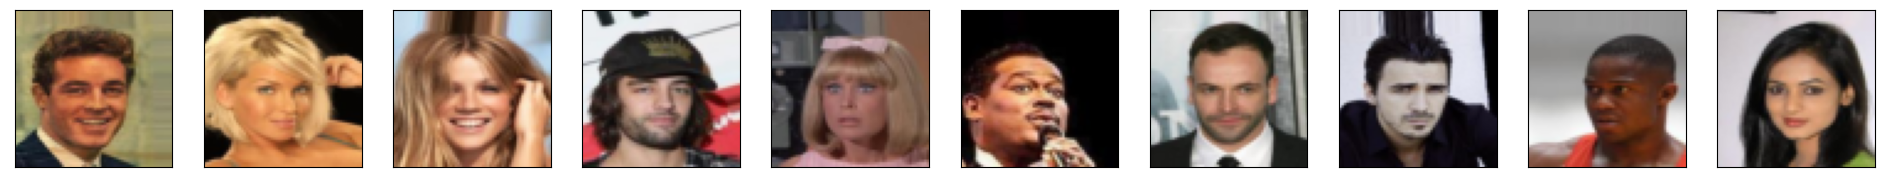

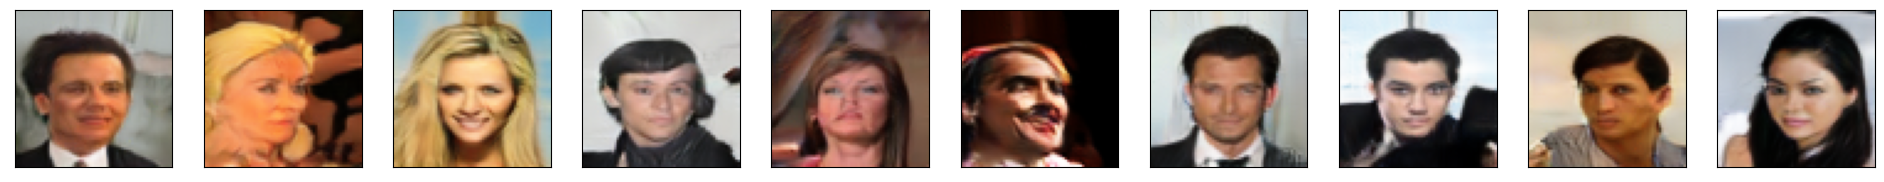

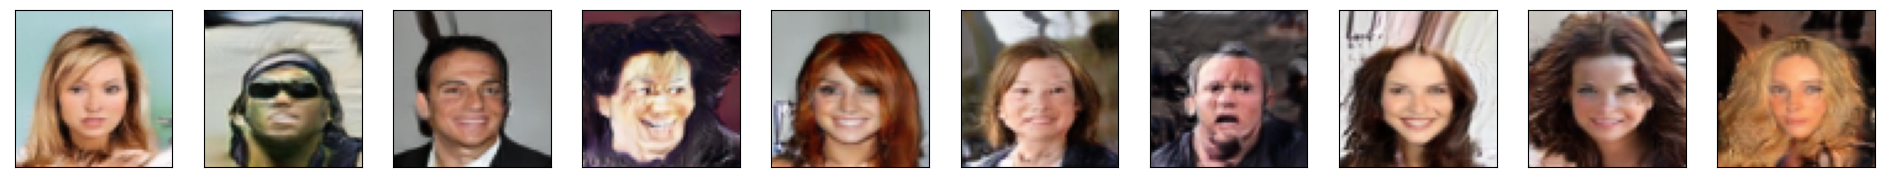

tensor([[1., 1., 1., 1., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.9216e-12, 3.1903e-36],
        [1.0000e+00, 0.0000e+00, 1.0000e+00, 3.3107e-15, 5.1024e-20, 5.4317e-18],
        [1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 8.4755e-13, 1.0786e-17],
        [2.1285e-29, 1.0000e+00, 9.0965e-34, 1.4045e-32, 5.4373e-25, 8.0826e-16],
        [0.0000e+00, 1.5985e-35, 0.0000e+00, 0.0000e+00, 8.0218e-23, 6.7495e-23],
        [8.1244e-21, 1.0000e+00, 2.0185e-24, 5.4747e-36, 7.7470e-18, 2.8533e-26],
        [4.5196e-21, 1.0000e+00, 1.0551e-27, 7.6665e-34, 1.7155e-13, 2.2707e-20],
        [0.0000e+00, 9.9963e-01, 0.0000e+00, 0.0000e+00, 3.9377e-23, 2.4100e-22],
   

In [81]:
t = 10
for batch_idx, (x, label) in enumerate(train_dataloader):
    with torch.no_grad():
        x = x.to('cpu')
        x_ = x[:t]
        x_recon = model(x, recon=True)[:10]
        x_recon = (x_recon * 0.5) + 0.5
        plot_image(x*0.5 + 0.5)
        plot_image(x_recon)
        
        z = torch.randn(x.size(0), latent_dim, device=x.device)
        x_fake = model(None, z)
        x_fake = x_fake * 0.5 + 0.5
        plot_image(x_fake)
        
        feat = torch.sigmoid(model.prior(model(x)[:t, :num_label]))
        print(label[:t, :])
        print(feat)
        
    break

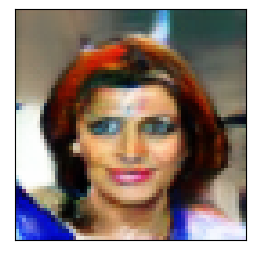

In [82]:
plt.figure(figsize=(3,3))
with torch.no_grad():
    temp = model(None, fixed_zeros)
    temp = np.transpose(temp.numpy(), (0, 2, 3, 1))[0]
    temp = temp*0.5 + 0.5
    plt.imshow(temp)
    plt.xticks([])
    plt.yticks([])

In [84]:
cols

['Smiling',
 'Male',
 'High_Cheekbones',
 'Mouth_Slightly_Open',
 'Narrow_Eyes',
 'Chubby']

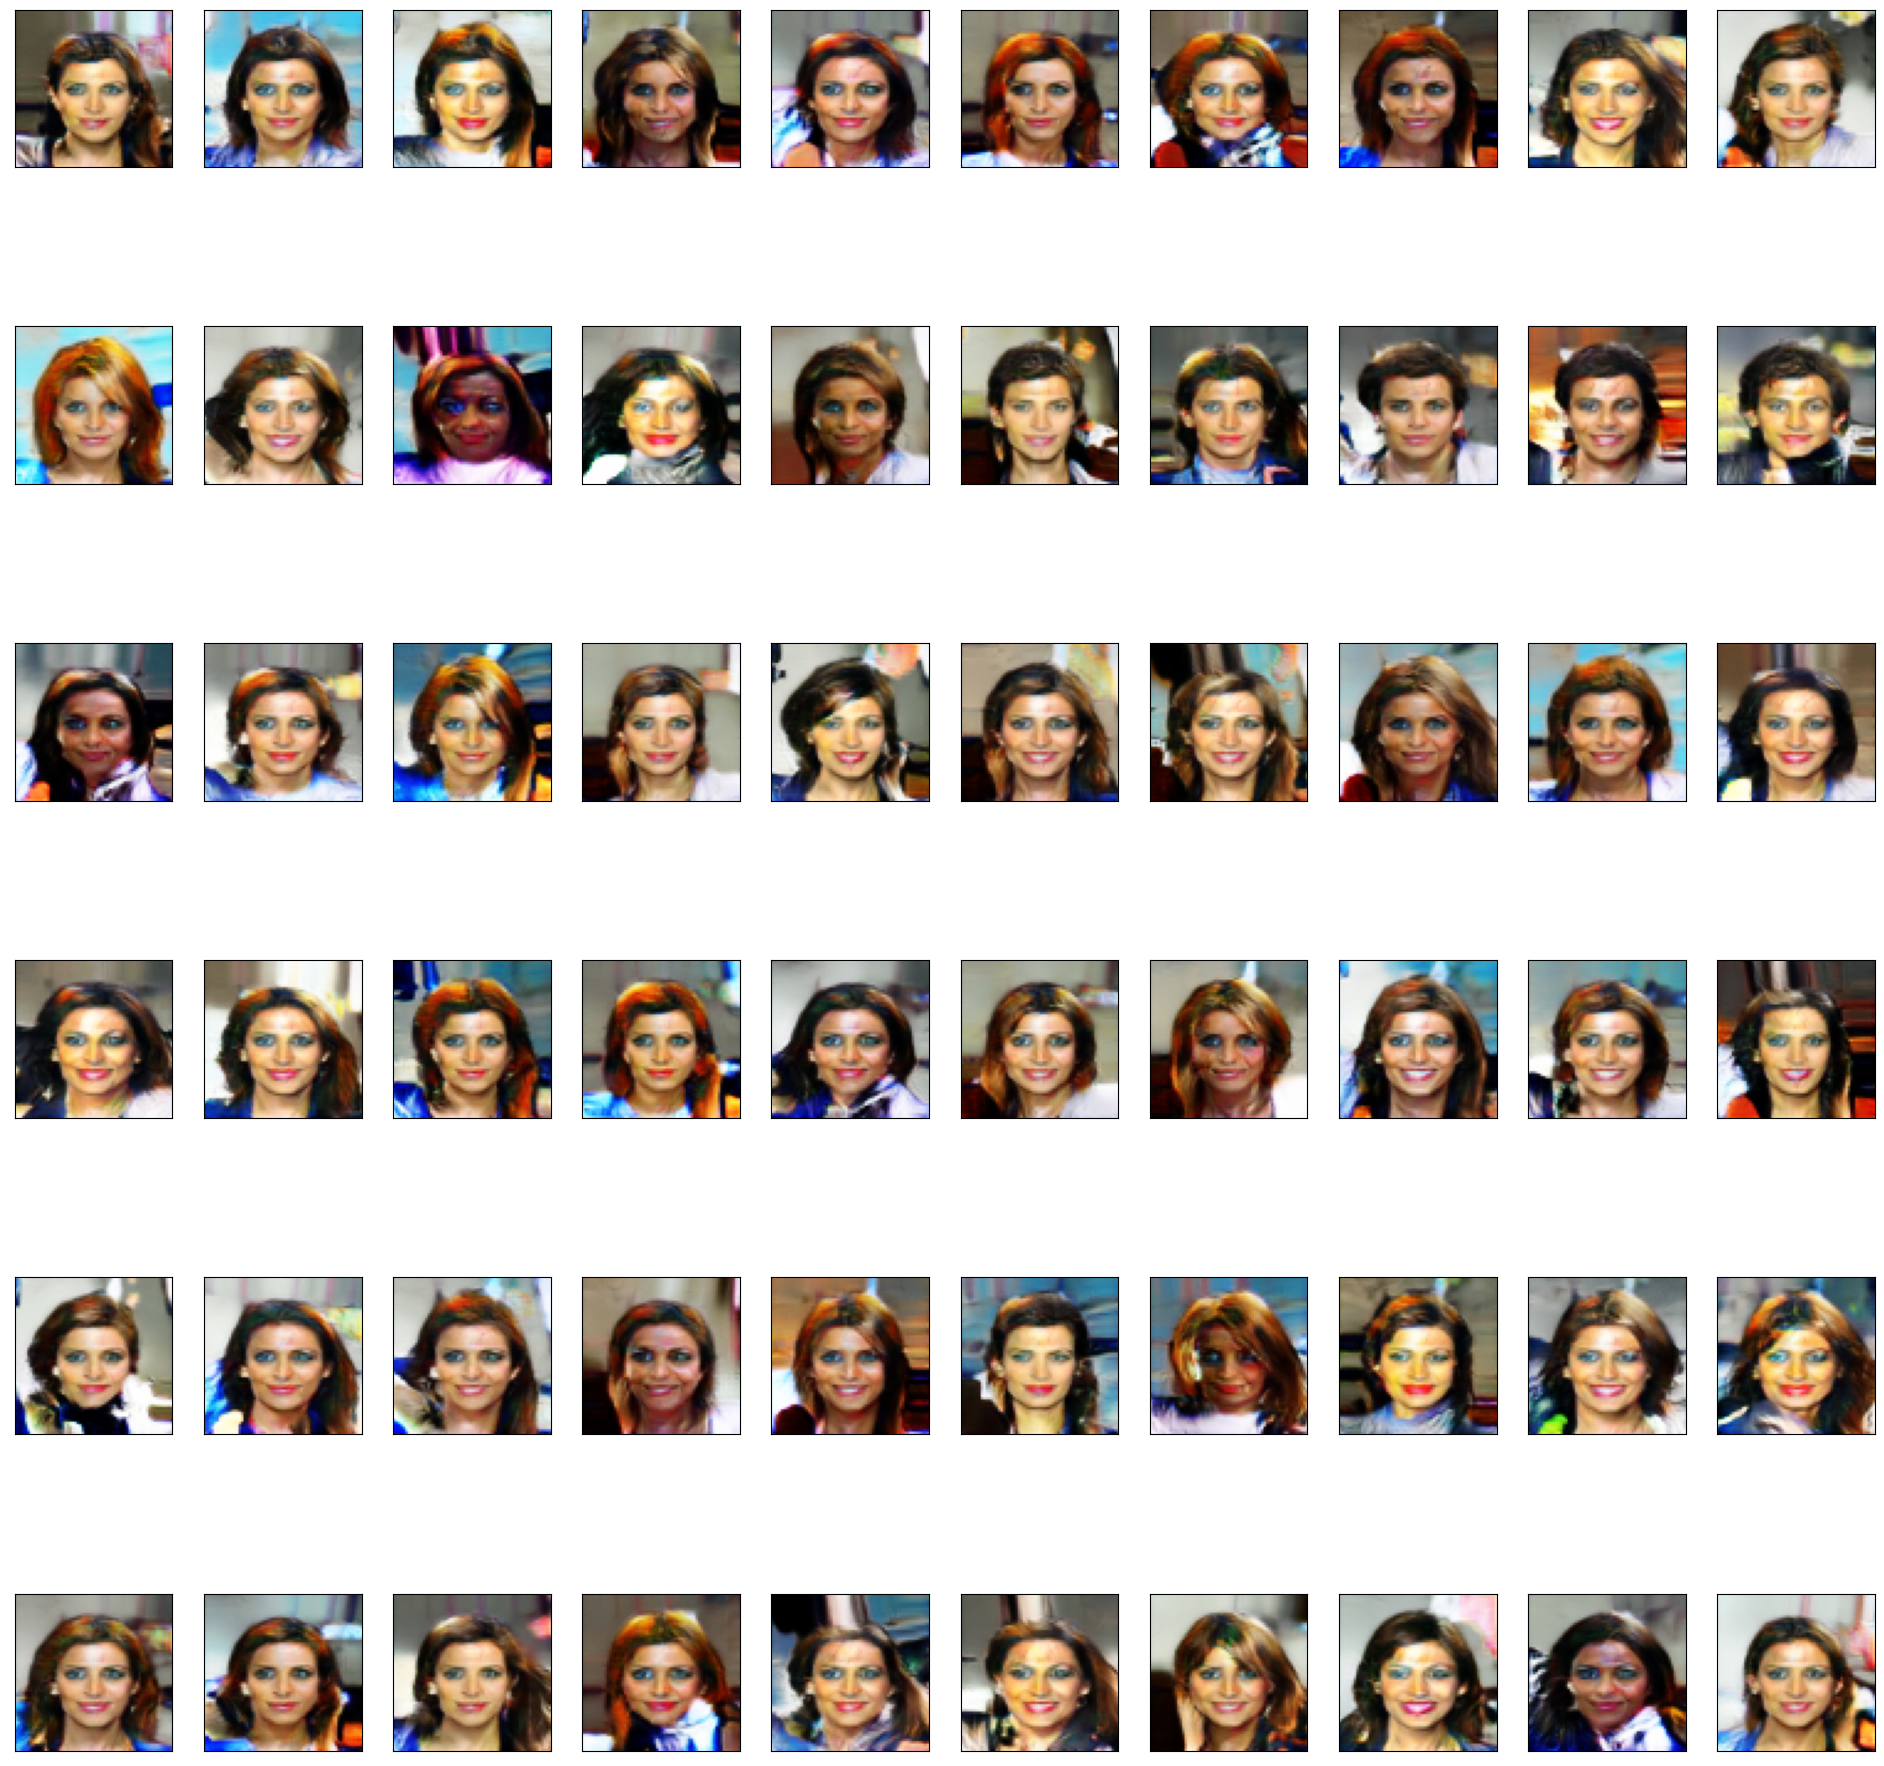

In [83]:
fixed_zeros = torch.zeros(1, latent_dim)
temp = model.traverse(fixed_zeros)
temp = temp * 0.5 + 0.5
plot_image(temp, r = 6, c = 10)